# Sentiment analysis with TF-IDF & BERT

Online store starts new service allows users to edit and add item's description like it does in wiki community. It need to be developed the tool to find toxic comments and send them to moderation. Our goal is to build model that predicts whethere comment toxic or not. F1 score has to be 0.75 or more. 

**Data describtion**

- *text* - text of comment
- *toxic* - binary data: 1 if comment is toxic, 0 if not

## Data Preprocessing

In [ ]:
# load and import librarys
!pip install transformers

     |████████████████████████████████| 3.1 MB 7.1 MB/s 
     |████████████████████████████████| 3.3 MB 35.1 MB/s 
     |████████████████████████████████| 895 kB 41.0 MB/s 
     |████████████████████████████████| 59 kB 5.9 MB/s 
     |████████████████████████████████| 596 kB 44.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install nltk

In [ ]:
!pip install contractions

     |████████████████████████████████| 321 kB 7.5 MB/s 
     |████████████████████████████████| 284 kB 52.2 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85447 sha256=63a8263f2244e6afc7399c8470ccb4734a7dcc22c02432f05221fb23f6b844c6
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import nltk
import transformers
from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, TransformerMixin
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from pymystem3 import Mystem
from nltk.stem import WordNetLemmatizer
import re
import sys
import contractions

from transformers import BertModel, BertConfig
from transformers import BertTokenizer, BertForNextSentencePrediction

import lightgbm as lgb

random_state = 12345

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#import data
data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Wikishop/toxic_comments.csv')

In [ ]:
data.sample(10)

,text,toxic
146736,Chai (symbol)\nI don't know the other guy doe...,0
149652,"FWIW ITN 'debates' never actually stop, WP:CCC...",0
97175,u wanna suck me off do it thats useful,1
60342,"""User:MiszaBot/config \n|archiveheader = \n|ma...",0
86391,This page is fucked up can someone please fix ...,1
43202,"although, they may be armed for defensive purp...",0
106036,Black text on a plain background elicited reli...,0
21339,Why does Wikipidia have such a copright law wh...,1
134712,Thanks Eeekster\nI don't know how to use Wikip...,0
129157,"arsenal\nim sorry, but i am not finished with ...",0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [ ]:
data['toxic'].unique()

array([0, 1])

In [ ]:
data['toxic'].value_counts(normalize=True)

0    0.898321
1    0.101679
Name: toxic, dtype: float64

In [ ]:
# brake off features and targets from dataset
X = data.drop('toxic', axis=1)
y = data['toxic']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state, stratify=y)

In [ ]:
# let's look at the shapes
sets = [X_train, X_test, y_train, y_test]
for _ in sets:
    print(_.shape)

(127656, 1)
(31915, 1)
(127656,)
(31915,)


### Text Vectorization

In [ ]:
# custom transformer
class TextTransformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    print('\n>>>>>>>init() called.\n')

  def fit(self, X, y = None):
    print('\n>>>>>>>fit() called.\n')
    return self

  def transform(self, X, y = None):
    print('\n>>>>>>>transform() called.\n')
    X_ = X.copy() # creating a copy to avoid changes to original dataset
    # function returns a lemmas
    def lemmatize(text):
        m = WordNetLemmatizer()
        lemm_list = m.lemmatize(text, 'v')
        lemm_text = "".join(lemm_list)
            
        return lemm_text

    # function cleans text from any marks
    def clear_text(text):
        return ' '.join(re.sub(r'[^a-zA-Z]', ' ', text).split())

    # function replaces short forms with long forms(I'm -> I am, for example)
    def expanded(text):
      return contractions.fix(text)
    
    X_['lem_text'] = X_['text'].apply(expanded).apply(clear_text).apply(lemmatize)
    corpus = X_['lem_text'].values.astype('U')
    
    return corpus

## Machine Learning

In [ ]:
# let's run LogisticRegression and calculate it's f1 score
clf = LogisticRegression(class_weight='balanced', random_state=random_state)


In [ ]:
#using pipeline to avoid data leakage
my_pipeline = Pipeline(steps=[
        ('preprocessor', TextTransformer()),
        ('tfidf', TfidfVectorizer(stop_words=set(nltk_stopwords.words('english')))),
        ('estimator', clf)
    ])


>>>>>>>init() called.



In [ ]:
my_pipeline.fit(X_train, y_train)


>>>>>>>fit() called.


>>>>>>>transform() called.



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Pipeline(steps=[('preprocessor', TextTransformer()),
                ('tfidf',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('estimator',
                 LogisticRegression(C=20, class_weight='balanced', max_iter=20,
                                    penalty='l1', random_state=12345,
                                    solver='liblinear'))])

In [ ]:
predict = my_pipeline.predict(X_test)
predict.shape


>>>>>>>transform() called.



(31915,)

In [ ]:
f1_score(y_test, predict)

0.7606955561689207

In [ ]:
# trying to improve metric by finding optimal hyperparameters
grid_params_lr = [{'estimator__penalty': ['l1', 'l2'],
        'estimator__C': [3.5, 20],
        'estimator__max_iter': [10, 20],
        'estimator__solver': ['liblinear']}] 

In [ ]:
gsearch_lr = GridSearchCV(estimator=my_pipeline,
            param_grid=grid_params_lr,
            scoring='f1_weighted',
            cv=5) 

gsearch_lr.fit(X_train, y_train)
print(gsearch_lr.best_params_)



>>>>>>>init() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.


>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.


>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.


>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.


>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.


>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.


>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.


>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.


>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.


>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.


>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.


>>>>>>>transform() called.


>>>>>>>init() called.


>

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.


>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.


>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.


>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.


>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.


>>>>>>>transform() called.


>>>>>>>init() called.


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.

{'estimator__C': 20, 'estimator__max_iter': 10, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:

f1_score(y_test, gsearch_lr.best_estimator_.predict(X_test))


>>>>>>>transform() called.



0.7777942704467864

In [ ]:
# run a dummy test
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=random_state)
dummy_clf.fit(X_train, y_train)
f1_score(y_test, dummy_clf.predict(X_test))

0.0

Our model's passed dummy test!  

## BERT

In [ ]:
# use not a whole dataset to be sure we'll not run out of a RAM  
data_ = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Wikishop/toxic_comments.csv')
data_ = data_.sample(1500, random_state=random_state).reset_index(drop=True)

In [ ]:
# toxic comments distribution is nearly the same
data_['toxic'].value_counts(normalize=True)

0    0.902
1    0.098
Name: toxic, dtype: float64

In [ ]:
# tokenize features
tokenizer = transformers.BertTokenizer(
    vocab_file='/content/gdrive/MyDrive/Colab Notebooks/Wikishop/vocab.txt')


tokenized = data_['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, padding=True, truncation=True, max_length=512))

token_lens = []
max_len = 0
for i in tokenized.values:
  token_lens.append(len(i))
  if len(i) > max_len:
    max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


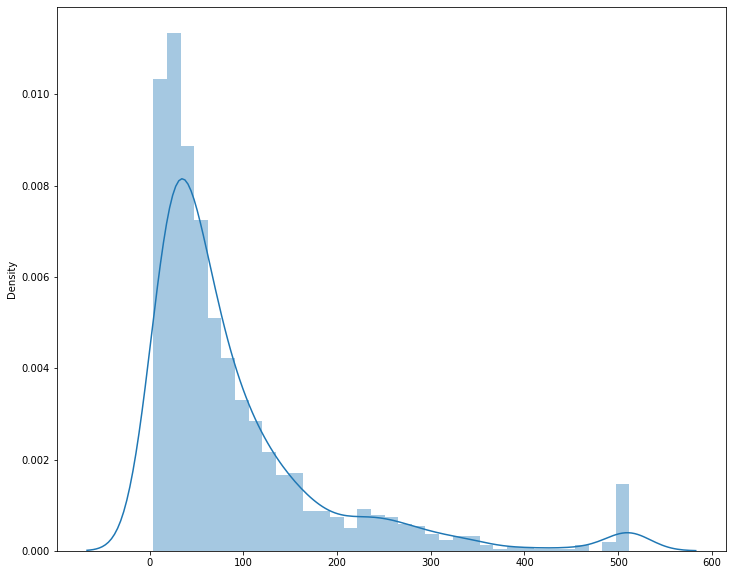

In [ ]:
# have a look at a token's lenghts distribution
plt.figure(figsize=(12,10))
ax = sns.distplot(token_lens)

In [ ]:
attention_mask.shape

(1500, 512)

In [ ]:
padded.shape

(1500, 512)

In [ ]:
# import model and settings
config = transformers.BertConfig.from_json_file(
    '/content/gdrive/MyDrive/Colab Notebooks/Wikishop/bert_config.json')
bert = transformers.BertModel.from_pretrained(
    '/content/gdrive/MyDrive/Colab Notebooks/Wikishop/pytorch_model.bin', config=config)

Some weights of the model checkpoint at /content/gdrive/MyDrive/Colab Notebooks/Wikishop/pytorch_model.bin were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# create features via BERT
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
  batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).cuda() 
  attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).cuda()
  print(attention_mask_batch.shape)
  print(batch.shape)      
  with torch.no_grad():
    bert.cuda()
    batch_embeddings = bert(batch, attention_mask=attention_mask_batch)
        
  embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
  del batch
  del attention_mask_batch
  del batch_embeddings

  0%|          | 0/15 [00:00<?, ?it/s]

torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])
torch.Size([100, 512])


In [ ]:
features = np.concatenate(embeddings)

In [ ]:
X = features
y = data_['toxic']

In [ ]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state, stratify=y)

In [ ]:
sets = [X_train, X_test, y_train, y_test]
for _ in sets:
    print(_.shape)

(1200, 768)
(300, 768)
(1200,)
(300,)


In [ ]:
clf = LogisticRegression(class_weight='balanced', C=20, max_iter=20, penalty='l1', solver='liblinear', random_state=random_state).fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
predict = clf.predict(X_test)
predict.shape

(300,)

In [ ]:
f1_score(y_test, predict)


0.7636363636363636

## Conclusion

In this project we built models capable to determine a toxic comments. we used two different ways to vectorize features - TF-IDF and BERT. Both of them can show almost the same results and match requirements (F1 score is equal or more then 0.75). But the second one can be learned on much less dataset (1500 vs 159,000). 